In [5]:
import pandas as pd
import glob

In [6]:
# Carpeta - data diaria
ruta = "data/raw/osinergmin/"  
archivos = sorted(glob.glob(ruta + "osinergmin_*.csv"))

print(f"Archivos: {len(archivos)}")

dfs = []

for archivo in archivos:
    try:
        df = pd.read_csv(archivo)
        df["__origen__"] = archivo  # para rastrear el archivo
        dfs.append(df)
    except Exception as e:
        print(f"Error leyendo {archivo}: {e}")

# Concatenar todo
osinerg = pd.concat(dfs, ignore_index=True)

# Remover duplicados por si existen repeticiones
osinerg = osinerg.drop_duplicates()
# osinerg.to_csv("data/consolidated/combustibles/osinergmin.csv", index=False)
osinerg.head(4)


Archivos: 19


,Distrito,Establecimiento,Dirección,Teléfono,Precio de Venta (Soles por galón),Departamento,Provincia,Producto,Fecha,Precio,__origen__
0,ANCON,CENTER GAS SAC,"PANAMERICANA NORTE KM 44.5, SUB LOTE A-1 ASOCI...",016788937/948581946/981530091,13.35,LIMA,LIMA,DB5 S-50 UV,2025-11-01,13.35,data/raw/osinergmin\osinergmin_01_11_2025.csv
1,ANCON,SERVICIOS DE COMBUSTIBLES SANTA FE E.I.R.L.,"AA.HH. LAS PALMERAS MZ. C, LT. 14 (ANTES SERPE...",016983211/960690748/996437408,13.35,LIMA,LIMA,DB5 S-50 UV,2025-11-01,13.35,data/raw/osinergmin\osinergmin_01_11_2025.csv
2,ANCON,ESTACIÓN DE SERVICIOS ANCÓN S.A.,"PANAMERICANA NORTE KM. 44, URB. SAN JOSE, MZ. ...",945635871/993487080,13.6,LIMA,LIMA,DB5 S-50 UV,2025-11-01,13.60,data/raw/osinergmin\osinergmin_01_11_2025.csv
3,ANCON,EMPRESA DE TRANSPORTES Y SERVICIOS VIRGEN DE L...,AV. LA FLORIDA CDRA. 12 MIRAMAR . LAS CONCHITAS,967743212,13.79,LIMA,LIMA,DB5 S-50 UV,2025-11-01,13.79,data/raw/osinergmin\osinergmin_01_11_2025.csv


<Axes: >

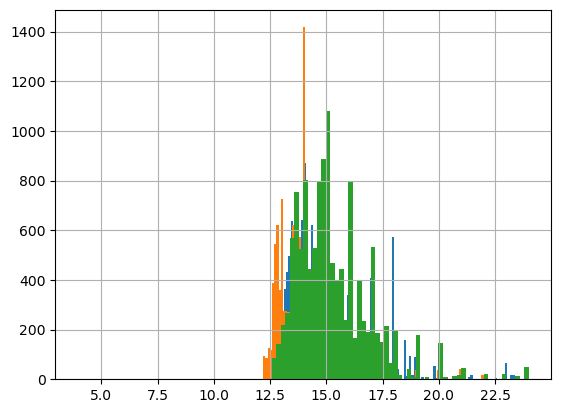

In [27]:
osinerg[osinerg["Producto"]=="DB5 S-50 UV"].Precio.hist(bins=100)
osinerg[osinerg["Producto"]=="Gasohol Regular"].Precio.hist(bins=100)
osinerg[osinerg["Producto"]=="Gasohol Premium"].Precio.hist(bins=100)

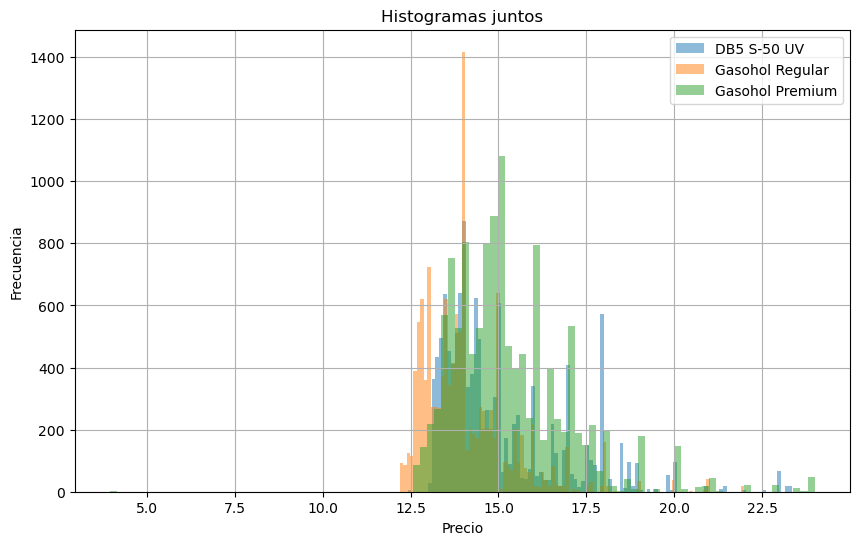

In [29]:
import matplotlib.pyplot as plt

# --- 1. Un solo gráfico con los tres histogramas juntos ---
plt.figure(figsize=(10,6))

osinerg[osinerg["Producto"]=="DB5 S-50 UV"]["Precio"].hist(bins=100, alpha=0.5)
osinerg[osinerg["Producto"]=="Gasohol Regular"]["Precio"].hist(bins=100, alpha=0.5)
osinerg[osinerg["Producto"]=="Gasohol Premium"]["Precio"].hist(bins=100, alpha=0.5)

plt.title("Histogramas juntos")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.legend(["DB5 S-50 UV", "Gasohol Regular", "Gasohol Premium"])
plt.show()

In [11]:
df = osinerg

In [13]:
import numpy as np

In [30]:
# df["Fecha"] = pd.to_datetime(df["Fecha"])

# --- Agrupar por día con PROMEDIO GEOMÉTRICO + STD ---
daily = df.groupby("Fecha").agg(
    promedio_geom = ("Precio", lambda x: np.exp(np.log(x).mean())),
    volatilidad   = ("Precio", "std")
).reset_index()

# Renombrar para que todo use el promedio geométrico
daily["precio_base"] = daily["promedio_geom"]

# Bandas geom ± std
daily["banda_sup"] = daily["precio_base"] + daily["volatilidad"]
daily["banda_inf"] = daily["precio_base"] - daily["volatilidad"]

# Orden
daily = daily.sort_values("Fecha").reset_index(drop=True)

# --- Base 100 usando el 29-10-2025 ---
base_fecha = pd.to_datetime("2025-10-29")

base_valor = daily.loc[daily["Fecha"] == base_fecha, "precio_base"]

if base_valor.empty:
    raise ValueError("No existe información para la fecha base 29-10-2025.")

base_valor = base_valor.iloc[0]

# Índices base 100
daily["idx"]     = 100 * daily["precio_base"] / base_valor
daily["idx_sup"] = 100 * daily["banda_sup"]   / base_valor
daily["idx_inf"] = 100 * daily["banda_inf"]   / base_valor

daily.head()


,Fecha,promedio_geom,volatilidad,precio_base,banda_sup,banda_inf,idx,idx_sup,idx_inf
0,2025-10-29,14.769112,1.718184,14.769112,16.487296,13.050928,100.000000,111.633632,88.366368
1,2025-10-30,14.761622,1.719820,14.761622,16.481441,13.041802,99.949285,111.593991,88.304580
2,2025-10-31,14.735681,1.679853,14.735681,16.415533,13.055828,99.773640,111.147736,88.399544
3,2025-11-01,14.737500,1.680930,14.737500,16.418430,13.056570,99.785960,111.167350,88.404571
4,2025-11-02,14.736922,1.679748,14.736922,16.416670,13.057174,99.782047,111.155432,88.408662


In [34]:
import plotly.graph_objects as go

fig = go.Figure()

# Línea principal
fig.add_trace(go.Scatter(
    x=daily["Fecha"],
    y=daily["idx"],
    mode="lines",
    name="Índice (Base 100)",
    line=dict(width=2)
))

# # Banda superior
# fig.add_trace(go.Scatter(
#     x=daily["Fecha"],
#     y=daily["idx_sup"],
#     mode="lines",
#     name="Banda superior",
#     line=dict(width=1, dash="dot")
# ))

# # Banda inferior
# fig.add_trace(go.Scatter(
#     x=daily["Fecha"],
#     y=daily["idx_inf"],
#     mode="lines",
#     name="Banda inferior",
#     line=dict(width=1, dash="dot")
# ))

# # Relleno entre bandas
# fig.add_trace(go.Scatter(
#     x=pd.concat([daily["Fecha"], daily["Fecha"][::-1]]),
#     y=pd.concat([daily["idx_sup"], daily["idx_inf"][::-1]]),
#     fill="toself",
#     fillcolor="rgba(0, 100, 200, 0.15)",
#     line=dict(color="rgba(0,0,0,0)"),
#     hoverinfo="skip",
#     showlegend=False
# ))

fig.update_layout(
    title="Índice Diario (Base 100 = 29/10/2025) usando Promedio Geométrico",
    xaxis_title="Fecha",
    yaxis_title="Índice (Base 100)",
    template="plotly_white",
    hovermode="x unified",
    width=900,
    height=500
)

fig.show()


In [36]:
fig = px.violin(
    df,
    x="Fecha",
    y="Precio",
    box=True,
    points="all",
    title="Distribución diaria de precios (violin plot por día)"
)

fig.update_layout(
    xaxis_title="Fecha",
    yaxis_title="Precio",
    width=1100, height=450
)

fig.show()
